# Project 3: Customer Behavior, Segmentation, and Churn Analysis

## Objective
- The objective of this project is to analyze customer purchasing behavior, identify distinct customer segments, and understand factors associated with customer churn using transactional data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('ecommerce_customer_data_custom_ratios.csv')

In [3]:
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,08-09-2020 09:38,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,05-03-2022 12:56,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,23-05-2022 18:18,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,12-11-2020 13:13,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,27-11-2020 17:55,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


## Initial Inspection

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202404 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


In [5]:
df.describe()

,Customer ID,Product Price,Quantity,Total Purchase Amount,Customer Age,Returns,Age,Churn
count,250000.00000,250000.000000,250000.000000,250000.000000,250000.000000,202404.000000,250000.000000,250000.000000
mean,25004.03624,254.659512,2.998896,2725.370732,43.940528,0.497861,43.940528,0.199496
std,14428.27959,141.568577,1.414694,1442.933565,15.350246,0.499997,15.350246,0.399622
min,1.00000,10.000000,1.000000,100.000000,18.000000,0.000000,18.000000,0.000000
25%,12497.75000,132.000000,2.000000,1477.000000,31.000000,0.000000,31.000000,0.000000
50%,25018.00000,255.000000,3.000000,2724.000000,44.000000,0.000000,44.000000,0.000000
75%,37506.00000,377.000000,4.000000,3974.000000,57.000000,1.000000,57.000000,0.000000
max,50000.00000,500.000000,5.000000,5350.000000,70.000000,1.000000,70.000000,1.000000


## Column Name Standardisation
- Column names are standardised to lowercase with underscores for readability and consistency. 

In [6]:
df.columns=(df.columns.str.strip().str.lower().str.replace(' ','_'))

## Datetime Conversion
- the 'purchase_date' column is converted to datetime datatype to enable time-based analysis.

In [7]:
df['purchase_date']=pd.to_datetime(df['purchase_date'].str.strip(),errors='coerce')

In [8]:
df['purchase_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 250000 entries, 0 to 249999
Series name: purchase_date
Non-Null Count  Dtype         
--------------  -----         
99828 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.9 MB


## Data Cleaning
- Minimal Cleaning is performed to preserve the original structure of the dataset.

#### Removal of Duplicate Age Column

The dataset contained two columns (customer_age and age) representing the same information.
To avoid redundancy and maintain a single source of truth, the customer_age column was removed while retaining the age column for analysis.

In [9]:
df=df.drop(columns=['customer_age']) 

In [10]:
df.isna().sum()

customer_id                   0
purchase_date            150172
product_category              0
product_price                 0
quantity                      0
total_purchase_amount         0
payment_method                0
returns                   47596
customer_name                 0
age                           0
gender                        0
churn                         0
dtype: int64

#### Handling Missing Values in Returns

The returns column is a binary indicator where:
- 1 represents a returned product
- 0 represents no return

Missing values in this column are interpreted as transactions where no return was recorded. 
Therefore, missing values were filled with 0 to indicate non-returned purchases. 
This allows accurate calculation of return rates at the customer level.

In [11]:
df['returns']=df['returns'].fillna(0).astype(int)

## Customer-Level Metrics
- Aggegating transactional data to build customer behavior profiles.

In [12]:
customer_df=(
    df.groupby('customer_id')
    .agg(
        total_spent=('total_purchase_amount','sum'),
        total_orders=('purchase_date','count'),
        avg_order_value=('total_purchase_amount','mean'),
        return_rate=('returns','mean'),
        churned=('churn','max')
    )
        .reset_index()
)

In [13]:
customer_df.head()

,customer_id,total_spent,total_orders,avg_order_value,return_rate,churned
0,1,3491,0,3491.000000,1.000000,0
1,2,7988,1,2662.666667,0.333333,0
2,3,22587,1,2823.375000,0.375000,0
3,4,8715,3,2178.750000,0.250000,1
4,5,12524,1,1565.500000,0.500000,0


## Customer Segmentation
- Customers are segmented based on spending behavior.

#### Customer Segmentation Logic

Customers are segmented based on their total spending behavior to create interpretable and business-relevant groups.

##### Segmentation Approach
The total spending (total_spent) distribution was divided into three groups using quantile thresholds:
- Bottom 33% → *Low Value Customers*
- Middle 33% → *Medium Value Customers*
- Top 34% → *High Value Customers*

Quantiles were chosen instead of fixed monetary thresholds to ensure balanced segment sizes and adaptability to the data distribution.

##### Rationale
- Quantile-based segmentation avoids arbitrary cutoffs.
- It ensures fair comparison across customers with different spending ranges.
- The resulting segments are intuitive and easily explainable to non-technical stakeholders.

This rule-based approach provides clear customer groupings without relying on complex models, making it suitable for exploratory analysis and business decision-making.

In [14]:
spend_quantiles = customer_df['total_spent'].quantile([0.33, 0.66])

def segment_customer(x):
    if x <= spend_quantiles[0.33]:
        return 'Low Value'
    elif x <= spend_quantiles[0.66]:
        return 'Medium Value'
    else:
        return 'High Value'

customer_df['segment'] = customer_df['total_spent'].apply(segment_customer)
customer_df.head()

,customer_id,total_spent,total_orders,avg_order_value,return_rate,churned,segment
0,1,3491,0,3491.000000,1.000000,0,Low Value
1,2,7988,1,2662.666667,0.333333,0,Low Value
2,3,22587,1,2823.375000,0.375000,0,High Value
3,4,8715,3,2178.750000,0.250000,1,Low Value
4,5,12524,1,1565.500000,0.500000,0,Medium Value


## Churn Analysis
- Comparing behaviour between churned and retained customers. 

In [15]:
customer_df.groupby('churned')[['total_spent','total_orders','avg_order_value']].mean()

,total_spent,total_orders,avg_order_value
churned,,,
0,13724.963530,2.014472,2723.829171
1,13682.976966,1.990646,2727.890713


## Customer Segment Distribution

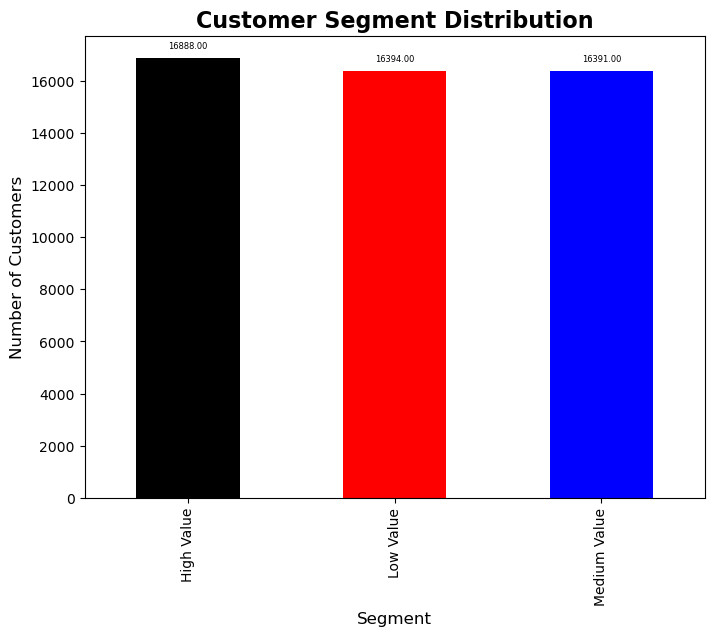

In [16]:
plt.figure(figsize=(8,6))
ax=customer_df['segment'].value_counts().plot(kind='bar',color=['k','r','b'])
plt.title('Customer Segment Distribution',fontsize=16, fontweight='bold')
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                xytext=(0, 5),
                textcoords='offset points'
               ,fontsize=6
               )


## Key Insights

### 1. Customer Spending Behavior and Churn
- The average total spending, order frequency, and average order value are remarkably similar between churned and retained customers.
- This indicates that churn in this dataset is *not strongly driven by spending intensity alone*.
- High spenders are just as likely to churn as lower spenders, suggesting that factors beyond monetary value influence customer retention.

### 2. Customer Segment Distribution
- Customers are evenly distributed across Low, Medium, and High Value segments.
- This balanced segmentation confirms the effectiveness of the quantile-based approach and ensures that comparisons across segments are statistically meaningful.

### 3. Churn Is Not Solely a Revenue Issue
- Since churned customers exhibit comparable spending patterns to retained customers, revenue-based targeting alone may be insufficient for retention strategies.
- Behavioral and experiential factors such as returns, product satisfaction, or payment experience may play a more significant role.

### 4. Interpretability of Rule-Based Segmentation
- The rule-based segmentation approach provides clear and explainable customer groups.
- This method enables business stakeholders to easily understand and act upon the results without relying on complex models.

## Conclusion

This project analyzed customer transaction data to understand purchasing behavior, segment customers based on spending patterns, and explore churn dynamics.

The analysis revealed that customer churn is not strongly correlated with total spending or order frequency, highlighting the importance of looking beyond revenue metrics when designing retention strategies. The balanced customer segmentation further supports the use of quantile-based grouping as an interpretable and effective analytical approach.

Overall, the project demonstrates practical customer analytics skills, including feature engineering, segmentation, and churn interpretation, making it highly relevant for real-world business and freelancing applications.